# Install & Import

In [ ]:
!pip install -U gradio

In [ ]:
# Imports
import os
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from io import BytesIO
import gdown
import gradio as gr

from tensorflow import keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Download CelebA Dataset (ZIP Format)

In [ ]:
# Download the CelebA dataset ZIP (images only)
url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM'
zip_path = '/content/img_align_celeba.zip'
gdown.download(url, zip_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=2b62b0f4-f861-4163-926b-e8d585455425
To: /content/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:23<00:00, 61.7MB/s]


'/content/img_align_celeba.zip'

# Load & Display Images from ZIP

In [ ]:
# Loads and resizes a limited number of images from a ZIP file
def load_images_from_zip(zip_path, target_size=(128, 128), max_images=20000):
    images = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        image_files = [f for f in zip_ref.namelist() if f.endswith('.jpg')]
        for i, file in enumerate(tqdm(image_files[:max_images])):  # Limit to 15,000 images
            with zip_ref.open(file) as image_file:
                img = cv2.imdecode(np.frombuffer(image_file.read(), np.uint8), cv2.IMREAD_COLOR)
                if img is not None:
                    img = cv2.resize(img, target_size)
                    images.append(img)
    return np.array(images)

# Displays an image (OpenCV format) in RGB
def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Load Images & Prepare Dataset

100%|██████████| 20000/20000 [00:07<00:00, 2661.48it/s]


Loaded image data shape: (20000, 128, 128, 3)
Train shape: (16000, 128, 128, 3)
Test shape: (4000, 128, 128, 3)


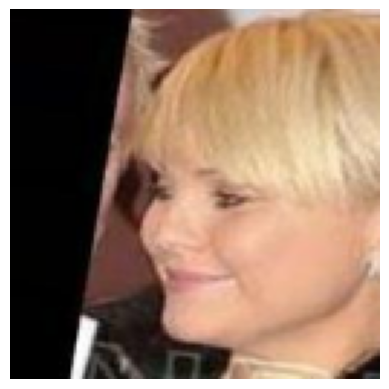

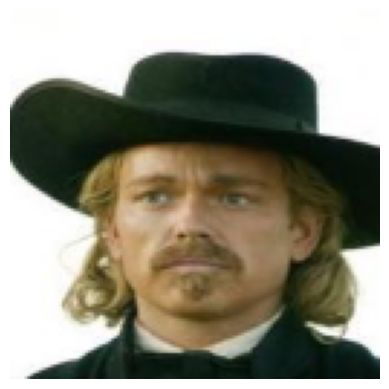

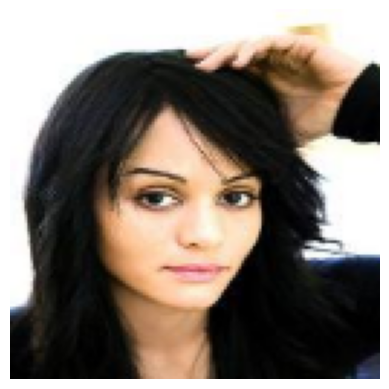

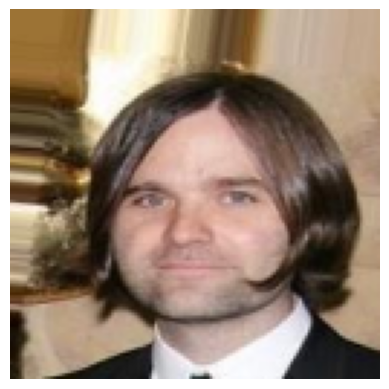

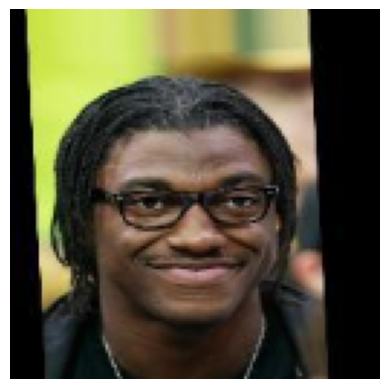

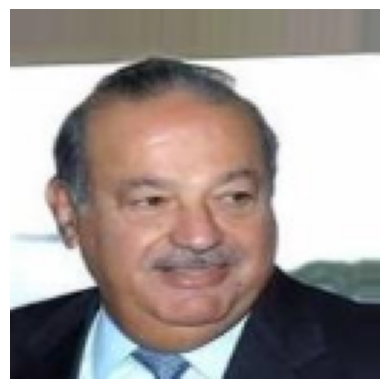

In [ ]:
# Load 10,000 images from the dataset
images = load_images_from_zip(zip_path, max_images=20000)
print("Loaded image data shape:", images.shape)

# Create dummy targets (autoencoder-style)
outputs = np.array([1] * len(images))

# Split into training and testing
x_train, x_test, _, _ = train_test_split(images, outputs, test_size=0.2, random_state=1, stratify=outputs)

print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)

# Display a few training examples
for img in x_train[:6]:
    show_image(img)

# Define Data Generator for Inpainting

In [ ]:
class createAugment(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, batch_size=32, dim=(128, 128), n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.y = y
        self.X = X
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idxs):
      X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
      y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))

      for i, idx in enumerate(idxs):
          tmp_image = self.X[idx].copy()

          h = w = np.random.randint(30, 60)
          x = np.random.randint(0, self.dim[1] - w)
          y = np.random.randint(0, self.dim[0] - h)

          mask = np.full(tmp_image.shape, 255, dtype=np.uint8)
          mask[y:y+h, x:x+w] = 0

          masked = cv2.bitwise_and(tmp_image, mask)

          X_batch[i] = masked / 255.0
          y_batch[i] = tmp_image / 255.0

      return X_batch, y_batch

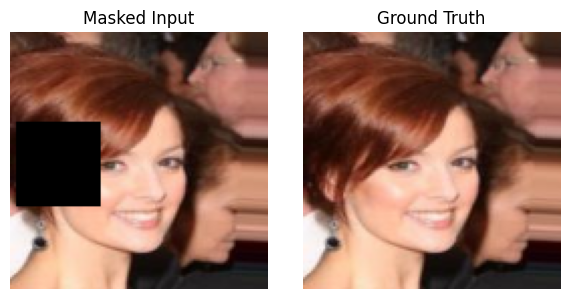

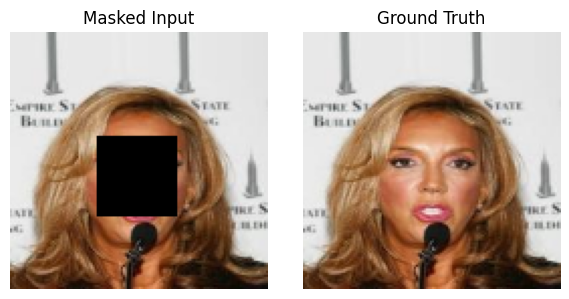

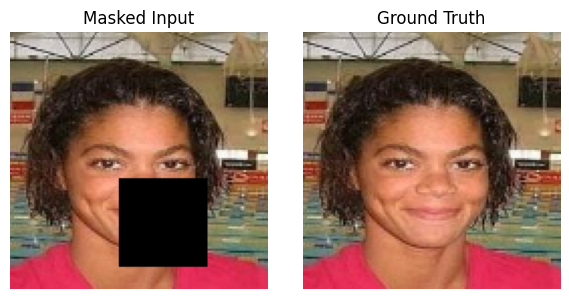

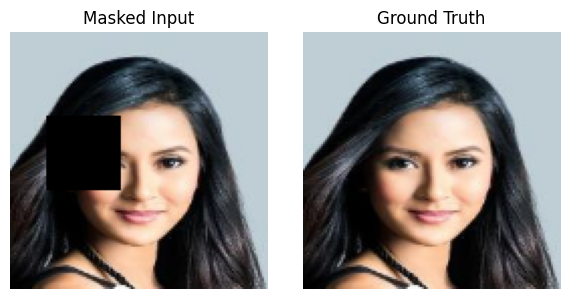

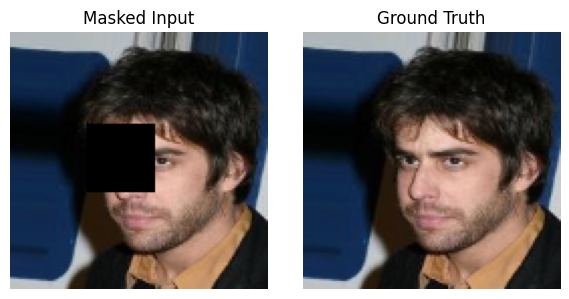

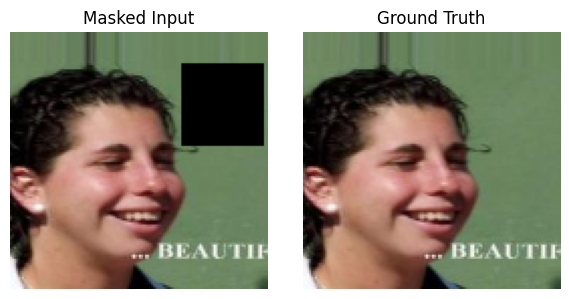

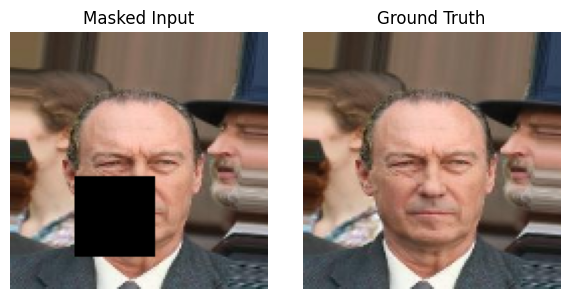

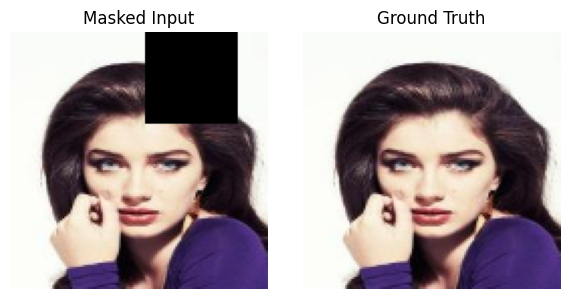

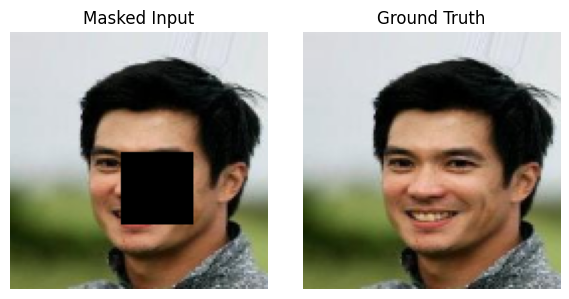

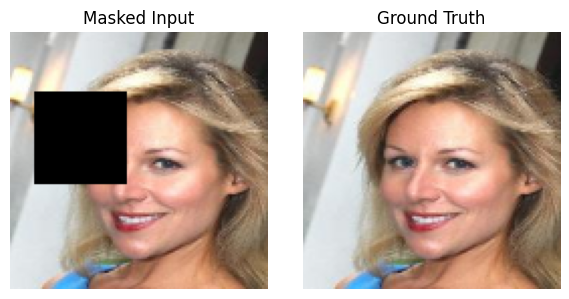

In [ ]:
# Training and validation generators
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test)

# Visualize only 10 images from a batch
sample_idx = 1
sample_images, sample_labels = traingen[sample_idx]

for i, (img, label) in enumerate(zip(sample_images, sample_labels)):
    if i >= 10:
        break  # Stop after showing 10 images

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Masked Input")
    axs[0].axis("off")

    axs[1].imshow(cv2.cvtColor((label * 255).astype('uint8'), cv2.COLOR_BGR2RGB))
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

# Define a U-Net-like Convolutional Neural Network

In [ ]:
def unet_like():
    inputs = keras.layers.Input((128, 128, 3))

    # Encoder
    c1 = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = keras.layers.MaxPooling2D(2)(c1)

    c2 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = keras.layers.MaxPooling2D(2)(c2)

    c3 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = keras.layers.MaxPooling2D(2)(c3)

    c4 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c4)
    p4 = keras.layers.MaxPooling2D(2)(c4)

    # Bottleneck
    c5 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(p4)
    c5 = keras.layers.Conv2D(512, 3, activation='relu', padding='same')(c5)
    c5 = keras.layers.Dropout(0.5)(c5)

    # Decoder
    u6 = keras.layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(u6)
    c6 = keras.layers.Conv2D(256, 3, activation='relu', padding='same')(c6)

    u7 = keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u7)
    c7 = keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c7)

    u8 = keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u8)
    c8 = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c8)

    u9 = keras.layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1])
    c9 = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(u9)
    c9 = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(c9)

    outputs = keras.layers.Conv2D(3, 1, activation='sigmoid')(c9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])

# Compile & Train the Model

In [ ]:
# Build the U-Net model
model = unet_like()

# Compile the model with binary crossentropy loss and accuracy metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model architecture summary
model.summary()

# Define EarlyStopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',       # Watch validation loss
    patience=3,               # Stop if no improvement for 3 epochs
    restore_best_weights=True
)

# Optional: Reduce learning rate if validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Train the model using training and validation generators
history = model.fit(
    traingen,
    validation_data=testgen,
    epochs=50,
    steps_per_epoch=len(traingen),
    validation_steps=len(testgen),
    callbacks=[early_stop, lr_scheduler]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8, 8, 512) │          0 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    524,544 │ dropout[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 7,760,163 (29.60 MB)

 Trainable params: 7,760,163 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


500/500 ━━━━━━━━━━━━━━━━━━━━ 109s 169ms/step - accuracy: 0.7363 - loss: 0.5412 - val_accuracy: 0.8524 - val_loss: 0.4865 - learning_rate: 0.0010
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 122s 164ms/step - accuracy: 0.8526 - loss: 0.4842 - val_accuracy: 0.8575 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 166ms/step - accuracy: 0.8726 - loss: 0.4810 - val_accuracy: 0.8849 - val_loss: 0.4816 - learning_rate: 0.0010
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.8839 - loss: 0.4798 - val_accuracy: 0.8741 - val_loss: 0.4807 - learning_rate: 0.0010
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.8892 - loss: 0.4796 - val_accuracy: 0.8632 - val_loss: 0.4817 - learning_rate: 0.0010
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 174ms/step - accuracy: 0.8922 - loss: 0.4785 - val_accuracy: 0.8909 - val_loss: 0.4801 - learning_rate: 0.0010
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 165ms/step - accuracy: 0.8904 -

# Plot Loss & Accuracy

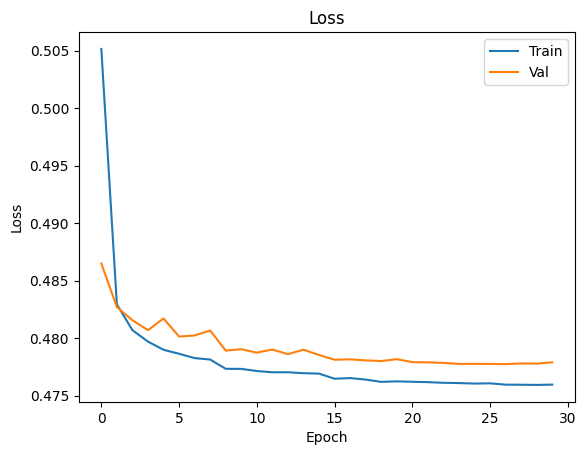

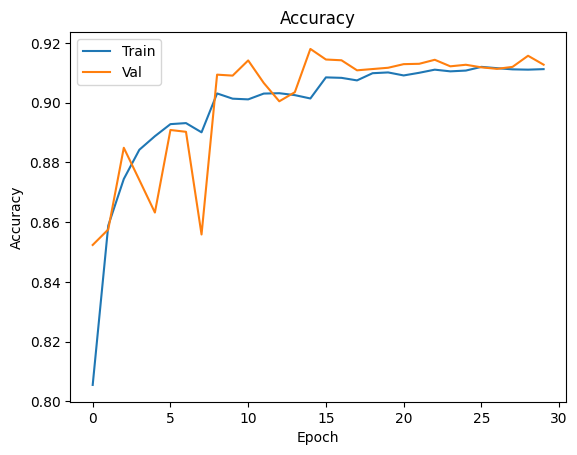

In [ ]:
# Plot loss over epochs
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save trained model
model.save('impaint_model.h5')

# Show Predictions vs Ground Truth

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


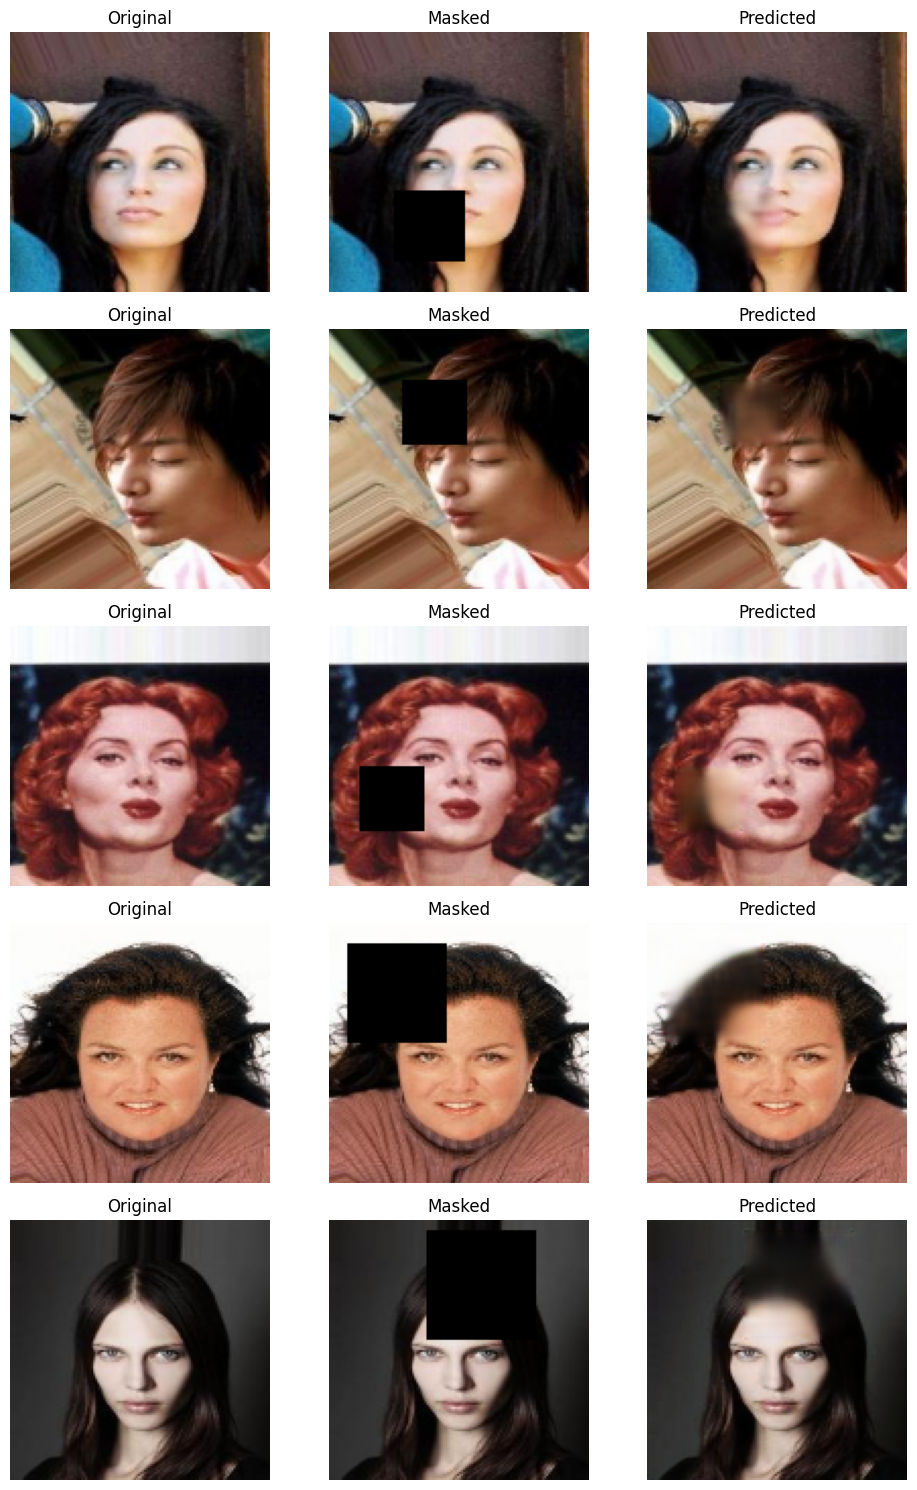

In [ ]:
# Show inpainting results from random validation batches
rows = 5
fig, axs = plt.subplots(rows, 3, figsize=(10, 15))

# Randomly sample 'rows' batches from the test generator
for i in range(rows):
    # Get one batch
    sample_images, sample_labels = testgen[np.random.randint(len(testgen))]

    # Pick a random image from the batch
    img_idx = np.random.randint(len(sample_images))

    masked = sample_images[img_idx]
    original = sample_labels[img_idx]

    # Run inpainting prediction
    pred = model.predict(masked.reshape(1, *masked.shape))[0]

    # Convert images to uint8 for display
    masked_disp = (masked * 255).astype(np.uint8)
    original_disp = (original * 255).astype(np.uint8)
    predicted_disp = (pred * 255).astype(np.uint8)

    # Show results: Original, Masked, Predicted
    axs[i][0].imshow(cv2.cvtColor(original_disp, cv2.COLOR_BGR2RGB))
    axs[i][0].set_title("Original")

    axs[i][1].imshow(cv2.cvtColor(masked_disp, cv2.COLOR_BGR2RGB))
    axs[i][1].set_title("Masked")

    axs[i][2].imshow(cv2.cvtColor(predicted_disp, cv2.COLOR_BGR2RGB))
    axs[i][2].set_title("Predicted")

    for j in range(3):
        axs[i][j].axis("off")

plt.tight_layout()
plt.show()

# Interactive Inpainting with Movable Mask

In [ ]:
def inpaint_fn(image, x=50, y=50):
    # Resize and normalize
    image = cv2.resize(image, (128, 128))
    image_norm = image.astype(np.float32) / 255.0

    # Prepare masked image
    masked = image_norm.copy()

    # Define mask dimensions
    w, h = 30, 30

    # Ensure mask stays within image bounds
    x = min(x, 128 - w)
    y = min(y, 128 - h)

    # Apply mask
    masked[y:y+h, x:x+w, :] = 0.0

    # Predict inpainted output
    pred = model.predict(np.expand_dims(masked, axis=0))[0]
    pred = np.clip(pred, 0, 1)

    # Convert all to uint8 for display
    image_disp = (image_norm * 255).astype(np.uint8)
    masked_disp = (masked * 255).astype(np.uint8)
    pred_disp = (pred * 255).astype(np.uint8)

    return image_disp, masked_disp, pred_disp

# Gradio Interface
gr.Interface(
    fn=inpaint_fn,
    inputs=[
        gr.Image(type="numpy", label="Upload Image"),
        gr.Slider(0, 98, value=50, step=1, label="X Position of Mask"),
        gr.Slider(0, 98, value=50, step=1, label="Y Position of Mask")
    ],
    outputs=[
        gr.Image(label="Original (Resized)"),
        gr.Image(label="Masked Image"),
        gr.Image(label="Inpainted Image")
    ],
    title="Image Inpainting Demo (Adjustable Mask)",
    description="Upload an image. Adjust the sliders to move the square mask around."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d89dc30e5b4194bfac.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
